In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2 
import time
import ffmpeg
%matplotlib inline

In [2]:
f = ImageFont.truetype('Courier New.ttf',20)

# Load TFLite model and allocate tensors.
model_name = "yolov5.tflite"
interpreter = tf.lite.Interpreter(model_path=model_name)
interpreter.allocate_tensors()



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

classes = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

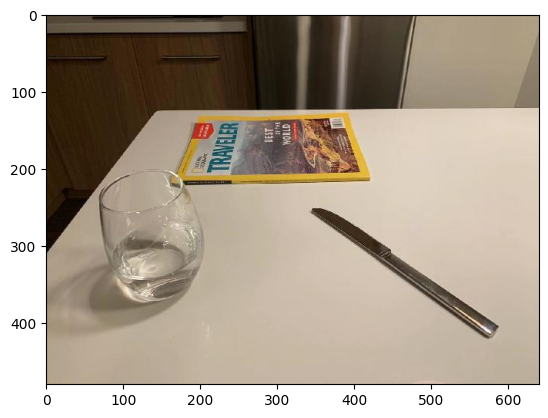

In [4]:
# img = Image.open('table.jpg')
img = Image.open('table.jpg')

# max_dim = max(img.width, img.height)
# padded = Image.new(img.mode, (max_dim,max_dim), 'black')
# padded.paste(img,(0,0))
# img=padded

plt.imshow(img)

In [12]:
def process_frame(img, input_details, output_details, font):
    input_shape = input_details[0]['shape']
    #data = np.array(img.resize(input_shape[1:3],Image.Resampling.LANCZOS), dtype=np.float32)
    data = cv2.resize(img, input_shape[1:3], interpolation = cv2.INTER_LANCZOS4).astype(np.float32)
    data /= 255.0
    data = data[np.newaxis,...]
    interpreter.set_tensor(input_details[0]['index'], data[...,:3])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]['index']).squeeze(0)
    boxes = result[...,0:4]
    boxes[...,0]*= img.shape[1]
    boxes[...,1]*= img.shape[0]
    boxes[...,2]*= img.shape[1]
    boxes[...,3]*= img.shape[0]
    scores = result[...,4:5].squeeze()
    selected = tf.image.non_max_suppression(
        boxes,
        scores,
        100,
        iou_threshold=0.2,
        score_threshold=0.4
    )
    draw_img = Image.fromarray( img)
    drawing = ImageDraw.Draw(draw_img)
    #f = ImageFont.truetype('Courier New.ttf',20)
    
    for ix in selected:
        res = result[ix,:]
        xywh = boxes[ix,:4]
        conf = res[5:]*res[4:5]
        clas = np.argmax(conf)
        #print(xywh, conf[clas], clas, classes[clas])
     
        drawing.rectangle([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2, xywh[0]+xywh[2]/2, xywh[1]+xywh[3]/2],
                          outline='green',width=3)
        drawing.text([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2],fill='white', 
                     stroke_width=3, stroke_fill='black',font=font,  text=f'{classes[clas]} @ {conf[clas]*100:.1f}%')
    return draw_img

In [13]:
def create_stream(rtmp_url, width, height, fps):
    process = (
        ffmpeg
        .input('pipe:', format='rawvideo',codec="rawvideo", pix_fmt='bgr24', s='{}x{}'.format(width, height))
        .output(
            rtmp_url,
            #codec = "copy", # use same codecs of the original video
            listen=1, # enables HTTP server
            pix_fmt="yuv420p",
            preset="ultrafast",
            f="flv"
        )
        .overwrite_output()
        .run_async(pipe_stdin=True)
    )
    return process


def write_frame(pipe, frame):
    pipe.stdin.write(frame.tobytes())

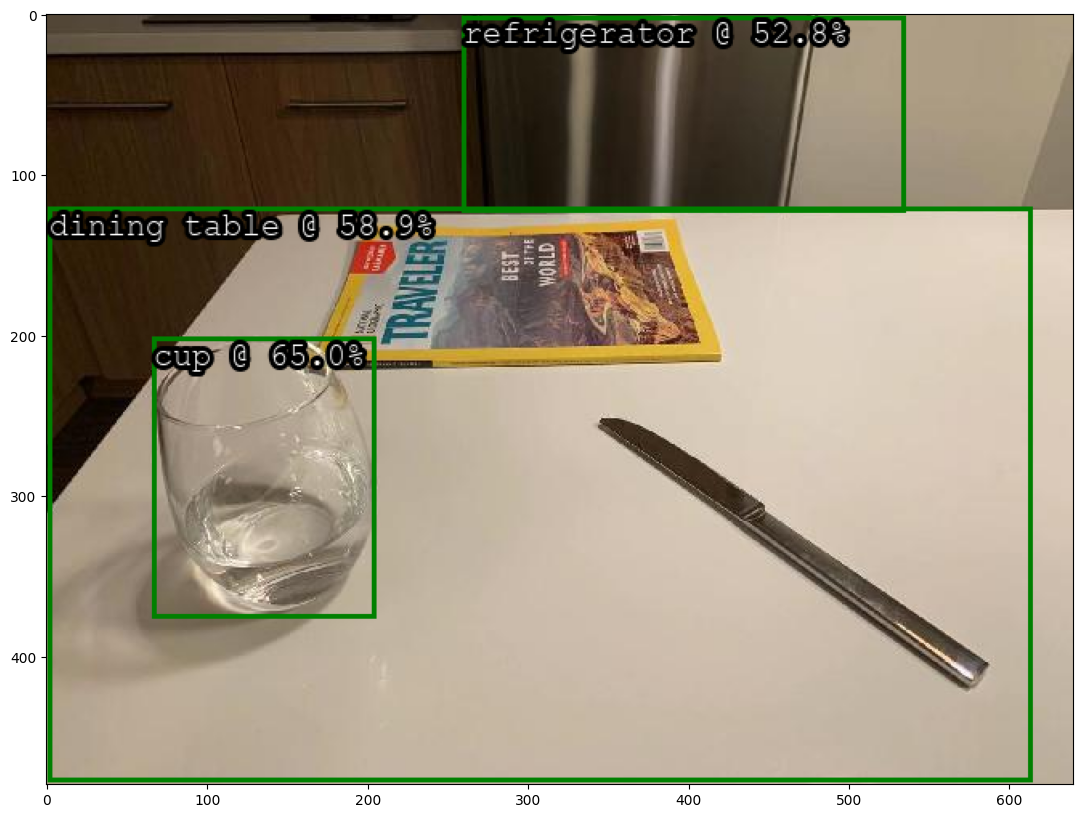

In [14]:
f = ImageFont.truetype('Courier New.ttf',20)

draw_img = process_frame(np.asarray(img), input_details, output_details, f)
plt.figure(figsize=(14,10))
plt.imshow(draw_img)

In [15]:
vid = cv2.VideoCapture(0)
FPS = 15
vid.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
vid.set(cv2.CAP_PROP_FPS, FPS)
SAVE = False
if SAVE:
    out = cv2.VideoWriter('out.mp4',  
                             cv2.VideoWriter_fourcc(*'mp4v'), 
                             FPS, (640,480))
stream = create_stream("http://localhost:8080/stream", 640, 480, FPS)
i = 0
while i< 20000: 
    t1 = time.time_ns()
    i+=1
    ret, vf = vid.read()
    if not ret:
        break
    frame = cv2.cvtColor(vf, cv2.COLOR_BGR2RGB)
    draw_img = process_frame(frame, input_details, output_details, f)
    
    out_frame = cv2.cvtColor(np.asarray(draw_img),cv2.COLOR_RGB2BGR)
    if SAVE:
        out.write(out_frame)
    write_frame(stream, out_frame)
    t2 = time.time_ns()
    st = 1/FPS - (t2-t1)/1e9
    if st > 0:
        time.sleep(st)
    
if SAVE:
    out.release()
vid.release()
stream.stdin.close()
stream.wait()


ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino -

BrokenPipeError: [Errno 32] Broken pipe